# Telescope Calibration Conversion Example

This notebook captures the methods I used to convert B side telescope temperatures, originally using the A side calibration polynomial curves, to the B side calibration curves.



In [13]:
import requests
from requests.auth import HTTPBasicAuth
from IPython.display import HTML, display
import json
from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
import numpy as np

from Chandra.Time import DateTime
from Ska.engarchive import fetch_eng as fetch

import sys
from os.path import expanduser
home = expanduser("~")

fottrendpath = home + '/AXAFLIB/fot_trend/'
sys.path.append(fottrendpath)
import fot_trend as ft

from plot_cxctime_custom import *


% matplotlib notebook

rcParams['xtick.major.pad'] = 10
rcParams['ytick.major.pad'] = 5
rc('font', family='sans-serif') 
rc('font', weight='light')


## Relevant MSIDS

In [2]:

ahp = ['OHRTHR49', 'OHRTHR24', 'OHRTHR05', 'OHRTHR19']
parab = ['OHRTHR10', 'OHRTHR11', 'OHRTHR34', 'OHRTHR35', 'OHRTHR55', 'OHRTHR56'] 
hypb = ['OHRTHR12', 'OHRTHR13', 'OHRTHR36', 'OHRTHR37', 'OHRTHR57', 'OHRTHR58']
cap = ['OHRTHR08', 'OHRTHR09', 'OHRTHR31', 'OHRTHR33', 'OHRTHR52', 'OHRTHR53', 'OHRTHR54']
fhp = ['OHRTHR44', 'OHRTHR02', 'OHRTHR21', 'OHRTHR45', 'OHRTHR03', 'OHRTHR22', 'OHRTHR46' ]
hmsids = ['OHRTHR02','OHRTHR03','OHRTHR04','OHRTHR05','OHRTHR06','OHRTHR07',
          'OHRTHR08','OHRTHR09','OHRTHR10','OHRTHR11','OHRTHR12','OHRTHR13', 
          'OHRTHR21','OHRTHR22','OHRTHR23','OHRTHR24','OHRTHR25','OHRTHR26',
          'OHRTHR27','OHRTHR29','OHRTHR30','OHRTHR36','OHRTHR37','OHRTHR42', 
          'OHRTHR33','OHRTHR44','OHRTHR45','OHRTHR46','OHRTHR47','OHRTHR49',
          'OHRTHR50','OHRTHR51','OHRTHR52','OHRTHR53','OHRTHR55','OHRTHR56']


## Function Definitions

In [3]:

def get_html_table(data):
    htmlcode = (HTML('<table><tr>{}</tr></table>'.format(
                     '</tr><tr>'.join(
                     '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data))))
    return htmlcode

# def gettelem(msid, t1, t2):
#     t1 = DateTime(t1).greta
#     t2 = DateTime(t2).greta
#     url_beginning = 'http://telemetry.cfa.harvard.edu'
#     url = url_beginning + '/maude/mrest/FLIGHT/' + msid.lower() + '.json?ts=' + t1 + '&tp=' + t2 + '&hr=t'
#     jsondata = requests.get(url, auth=HTTPBasicAuth('mdahmer', '!0ccJRQU'))
#     d = dict(jsondata.json())
#     times = np.array(d['data-fmt-1']['times'])
#     times = DateTime(np.array(times)/1.e9, format='greta').secs
#     vals = np.array(d['data-fmt-1']['values'], dtype=np.float64)
#     return times, vals

def gettelem(msid, t1, t2):
    data = fetch.Msid(msid, t1, t2, stat=None)
    return data.times, data.vals
    
    
def readcalib(filename):
    with open(filename, 'r') as fid:
        lines = fid.readlines()
    calib = {}
    for line in lines:
        line = [v.strip() for v in line.split(',')]
        if line[0] not in calib.keys():
            calib.update({line[0]:{'a':{}, 'b':{}}})
        calib[line[0]][line[2]].update({'type':line[1], 'coef':[float(c) for c in line[3:]] })
        if 'poly' in line[1]:
            calib[line[0]][line[2]]['coef'].reverse()
    return calib

def getcounts(temps, coef):
    n=len(temps)
    ps = np.tile(coef, (n, 1))
    ps[:,3] = ps[:,3]-temps
    rarray = np.array([np.real(np.roots(pv)) for pv in ps])
    rkeep = np.array([r[(r >= 0) & (r <= 1024)][0] for r in rarray])
#     return np.rint(rkeep)
    return rkeep

def get_corrected_temps(times, vals, msidcalib):
    kind = msidcalib['a']['type']
    if 'poly' in kind:
        acoef = msidcalib['a']['coef']
        bcoef = msidcalib['b']['coef']
        fixed_temps = np.array([np.nan,] * len(vals))
        counts = getcounts(vals, acoef) # initially all use A side calibration

        for t in atimes:
            t = DateTime(t).secs
            ind = (times >= t[0]) & (times <= t[1])
            fixed_temps[ind] = np.polyval(acoef, counts[ind])

        for t in btimes:
            t = DateTime(t).secs
            ind = (times >= t[0]) & (times <= t[1])
            fixed_temps[ind] = np.polyval(bcoef, counts[ind])

        return fixed_temps
    
    elif 'lin' in kind:
        return vals # no difference in calibration
    

## Read Calibration

This includes polynomial coefficients for each MSID, will not be in the Github repository for proprietary reasons.

In [4]:
calib = readcalib('tel_calib.csv')

## Define Time Span, Determine A/B Time Spans

In this case this is a smaller span of data that excludes the data collected during the safe mode, before the SCS 26 safing action.

In [5]:
t1b = '2016:065:12:00:00'
t2b = '2016:067:02:00:00'

times, vals = gettelem('4prt1at', t1b, t2b)
aside = vals > -80
inds = ft.find_span_indices(aside)
atimes = ft.find_time_spans(times, inds)

times, vals = gettelem('4prt1bt', t1b, t2b)
bside = vals > -80
inds = ft.find_span_indices(bside)
btimes = ft.find_time_spans(times, inds)

## Calculate Corrected Temperatures

In [6]:
plotdata = {}

hrma_ave = []
for msid in hmsids:
    times, vals = gettelem(msid, t1b, t2b )
    fixed_vals = get_corrected_temps(times, vals, calib[msid.upper()])
    notnans = ~np.isnan(fixed_vals)
    fivemin_times, fivemin_vals, _, _ = ft.calc_5min_stats(times, vals, vals, vals)
    _, fivemin_fixed_vals, _, _ = ft.calc_5min_stats(times, fixed_vals, fixed_vals, fixed_vals)

    plotdata[msid] = {'times':times, 'vals':vals, 'fixed_vals':fixed_vals, 'notnans':notnans,
                      'fivemin_times':fivemin_times, 'fivemin_vals':fivemin_vals,
                      'fivemin_fixed_vals':fivemin_fixed_vals}

interptimes = plotdata[msid]['times']
hrma_ave = np.zeros(len(interptimes))

for msid in hmsids:
    vals = np.interp(interptimes, plotdata[msid]['times'], plotdata[msid]['vals'])
    hrma_ave = hrma_ave + vals
hrma_ave = hrma_ave / len(hmsids)

/Users/wolf809/Anaconda/anaconda/envs/skamatt3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/Users/wolf809/Anaconda/anaconda/envs/skamatt3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/wolf809/Anaconda/anaconda/envs/skamatt3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Fetch Data for Wider Time Span

This fetches hrma_ave directly and fills in the corrected data

In [7]:
t1 = '2016:061:23:55:00'
t2 = '2016:070:00:05:00'
data = fetch.Msidset(['hrma_ave', 'pitch'],t1, t2, stat=None)
data.interpolate()
hrmaave = data['hrma_ave']
pitch = data['pitch']
pitch.vals[pitch.vals < 45] = 90

ind = np.where((hrmaave.times > DateTime(t1b).secs) & (hrmaave.times < DateTime(t2b).secs))[0]
hrmaave.vals[ind] = np.interp(hrmaave.times[ind], interptimes, hrma_ave)


## Note Max HRMA_AVE temperature

In [8]:
np.max(hrmaave.vals)

71.542816

## Plot Zoomed HRMA_AVE Trend

<IPython.core.display.Javascript object>


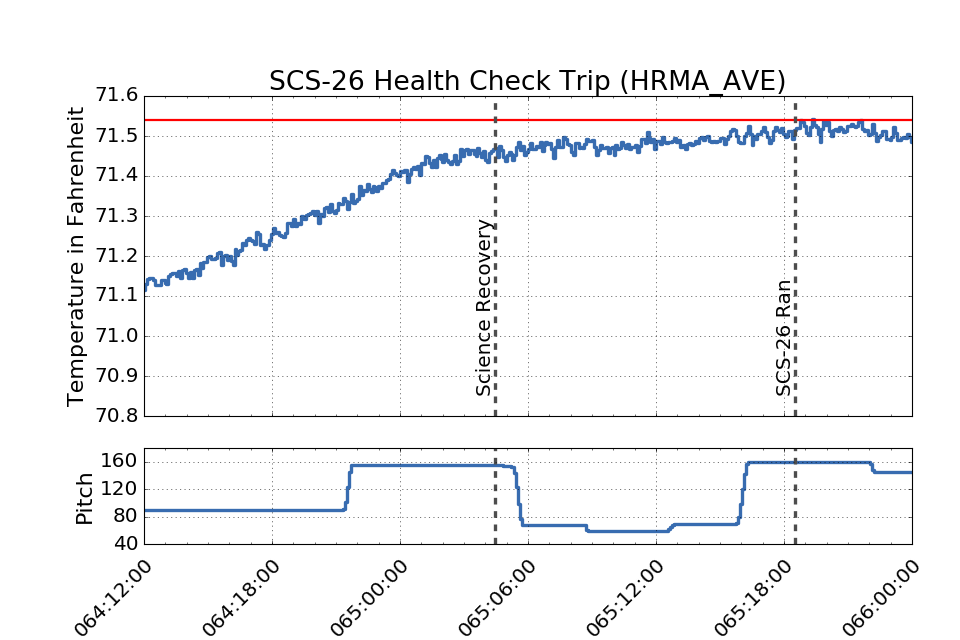

(736027.5, 736029.0)

In [9]:
fig = plt.figure(facecolor=[1,1,1],figsize=(12,8))
ax = fig.add_axes([.15, .35, .8, .5])
ax.hold(True)
plot_cxctime(data.times, hrmaave.vals, 
                label='HRMA_AVE Telemetry', color='#386cb0', linewidth=3,
                fig=fig, ax=ax)
ax.grid(True)
# ax.legend(loc='best')
ax.set_ylabel('Temperature in Fahrenheit', fontsize=20)
ax.set_title('SCS-26 Health Check Trip (HRMA_AVE)', fontsize=24)
fig.set_facecolor('w')
xlim = [DateTime('2016:064:12:00:00').secs, DateTime('2016:066:00:00:00').secs]

xlimplot = cxctime2plotdate(xlim)

plot_cxctime(xlim, [71.54, 71.54], label='Trip Threshold', color='r', linewidth=2, 
             fig=fig, ax=ax)
ax.axvline(x=cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:066:18:30:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.text(cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), 71.1, 'Safe Mode Trip',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), 70.85, 'Science Recovery',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), 70.85, 'SCS-26 Ran',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:066:12:00:00').secs,]), 70.85, 'Recoverd to\nTel. A Side',
       rotation=90, fontsize=18, ha='center', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:068:12:00:00').secs,]), 71.52, 'Trip Threshold',
       fontsize=18, ha='center', va='top')


ax.set_xlim(xlimplot)
ax.set_ylim(70.8, 71.6)
ax.set_xticklabels('')
ax.set_yticklabels(ax.get_yticks(), fontsize=18)

ax2 = fig.add_axes([.15, .15, .8, .15])
ax2.hold(True)

plot_cxctime(data.times, pitch.vals, 
                label='Pitch', color='#386cb0', linewidth=3, fig=fig, ax=ax2)
ax2.grid(True)
# ax.legend(loc='best')
ax2.set_ylabel('Pitch', fontsize=20)
ax2.set_yticks(np.arange(40, 185, 40))
ax2.set_yticklabels(ax2.get_yticks(), fontsize=18)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18, rotation=45, 
                    rotation_mode='anchor', ha='right' )
ax2.axvline(x=cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:066:18:30:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)

ax2.set_xlim(xlimplot)


## Plot Longer HRMA_AVE Trend

<IPython.core.display.Javascript object>


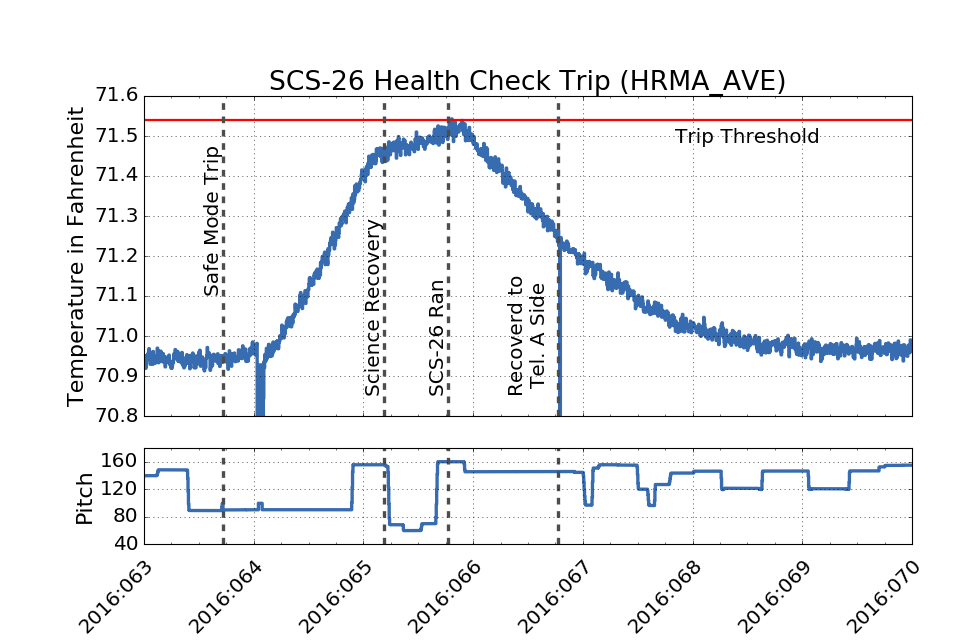

(736026.0, 736033.0)

In [10]:

fig = plt.figure(facecolor=[1,1,1],figsize=(12,8))
ax = fig.add_axes([.15, .35, .8, .5])
ax.hold(True)
plot_cxctime(data.times, hrmaave.vals, 
                label='HRMA_AVE Telemetry', color='#386cb0', linewidth=3,
                fig=fig, ax=ax)
ax.grid(True)
# ax.legend(loc='best')
ax.set_ylabel('Temperature in Fahrenheit', fontsize=20)
ax.set_title('SCS-26 Health Check Trip (HRMA_AVE)', fontsize=24)
fig.set_facecolor('w')

xlim = [DateTime('2016:063:00:00:00').secs, DateTime('2016:070:00:00:00').secs]

xlimplot = cxctime2plotdate(xlim)

plot_cxctime(xlim, [71.54, 71.54], label='Trip Threshold', color='r', linewidth=2, 
             fig=fig, ax=ax)
ax.axvline(x=cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.axvline(x=cxctime2plotdate([DateTime('2016:066:18:30:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax.text(cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), 71.1, 'Safe Mode Trip',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), 70.85, 'Science Recovery',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), 70.85, 'SCS-26 Ran',
       rotation=90, fontsize=18, ha='right', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:066:12:00:00').secs,]), 70.85, 'Recoverd to\nTel. A Side',
       rotation=90, fontsize=18, ha='center', va='bottom')
ax.text(cxctime2plotdate([DateTime('2016:068:12:00:00').secs,]), 71.52, 'Trip Threshold',
       fontsize=18, ha='center', va='top')


ax.set_xlim(xlimplot)

ax.set_ylim(70.8, 71.6)
ax.set_xticklabels('')
ax.set_yticklabels(ax.get_yticks(), fontsize=18)

ax2 = fig.add_axes([.15, .15, .8, .15])
ax2.hold(True)

plot_cxctime(data.times, pitch.vals, 
                label='Pitch', color='#386cb0', linewidth=3, fig=fig, ax=ax2)
ax2.grid(True)
# ax.legend(loc='best')
ax2.set_ylabel('Pitch', fontsize=20)
ax2.set_yticks(np.arange(40, 185, 40))
ax2.set_yticklabels(ax2.get_yticks(), fontsize=18)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18, rotation=45, 
                    rotation_mode='anchor', ha='right' )
ax2.axvline(x=cxctime2plotdate([DateTime('2016:065:18:29:43').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:065:04:28:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:063:17:11:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.axvline(x=cxctime2plotdate([DateTime('2016:066:18:30:00').secs,]), color=[0.3, 0.3, 0.3], 
           linestyle='--', linewidth=3)
ax2.set_xlim(xlimplot)



# fig.savefig('HRMA_AVE.png', bbox_to_inches='tight', facecolor='w', edgecolor='w')

## Plot Individual HRMA Temperatures and Calibration Differences

<IPython.core.display.Javascript object>


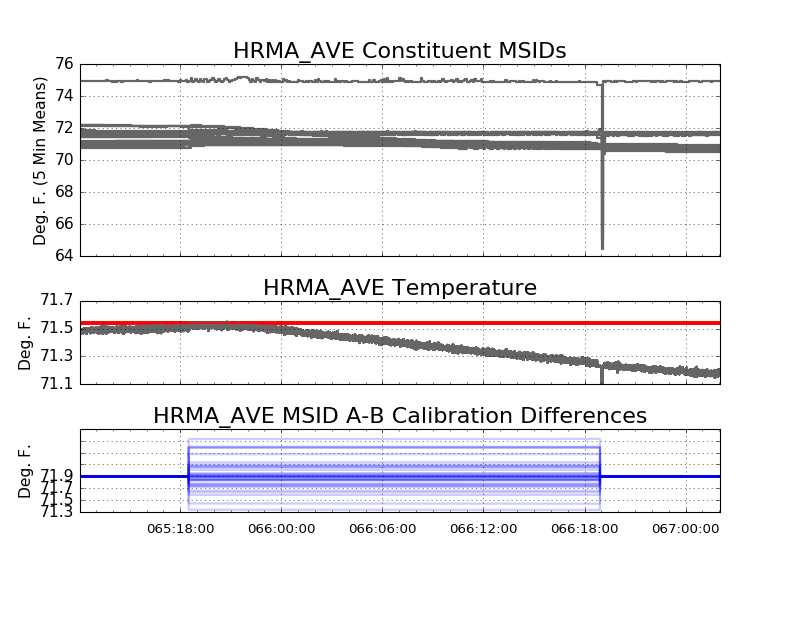

(-0.2, 0.2)

In [11]:

fig = plt.figure(facecolor=[1,1,1],figsize=(10,8))

ax = fig.add_axes([.1, .6, .8, .3])
ax.hold(True)
ax.grid(True)
ax.set_ylabel('Deg. F. (5 Min Means)', fontsize=14)
ax.set_title('HRMA_AVE Constituent MSIDs', fontsize=20)

ax2 = fig.add_axes([.1, .4, .8, .13])
ax2.set_ylabel('Deg. F.', fontsize=14)
ax2.set_title('HRMA_AVE Temperature', fontsize=20)

ax3 = fig.add_axes([.1, .2, .8, .13])
ax3.set_ylabel('Deg. F.', fontsize=14)
ax3.set_title('HRMA_AVE MSID A-B Calibration Differences', fontsize=20)

for msid in hmsids:
    fivemin_times = plotdata[msid]['fivemin_times']
    fivemin_vals = plotdata[msid]['fivemin_vals']
    times = plotdata[msid]['times']
    vals = plotdata[msid]['vals']
    notnans = plotdata[msid]['notnans']
    fixed_vals = plotdata[msid]['fixed_vals']

    _ = plot_cxctime(fivemin_times, fivemin_vals, color=[.4, .4, .4], linewidth=2, alpha=1, fig=fig, ax=ax)
    _ = plot_cxctime(interptimes, hrma_ave, color=[.4, .4, .4], linewidth=2, alpha=1, fig=fig, ax=ax2)
    _ = plot_cxctime([interptimes[0], interptimes[-1]], [71.54, 71.54], color='r', linewidth=2, alpha=0.7, fig=fig, ax=ax2)

    _ = plot_cxctime(times[notnans], vals[notnans]-fixed_vals[notnans], color='b', 
                     linewidth=2, alpha=0.2, fig=fig, ax=ax3)

xlim = ax.get_xlim()
ax.set_yticklabels([a.get_text() for a in ax.get_yticklabels()], fontsize=14)
ax.set_xticklabels('')

ax2.set_yticks(np.arange(71.1, 72.0, .2))
ax3.set_yticklabels(np.arange(71.1, 72.0, .2), fontsize=14)

ax2.set_yticklabels(np.arange(71.1, 71.8, 0.2), fontsize=14)
ax2.set_ylim(71.1, 71.7)
ax2.grid(True)
ax2.set_xlim(xlim)
ax2.set_xticklabels('')

ax3.grid(True)
ax3.set_xlim(xlim)
ax3.set_yticks(np.arange(-0.3, 0.25, 0.1))
ax3.set_yticklabels(np.around(np.arange(-0.3, 0.25, 0.1), 2), fontsize=14)
ax3.set_ylim(-0.2, 0.2)




## Plot HRMA MSIDS and Pitch

<IPython.core.display.Javascript object>


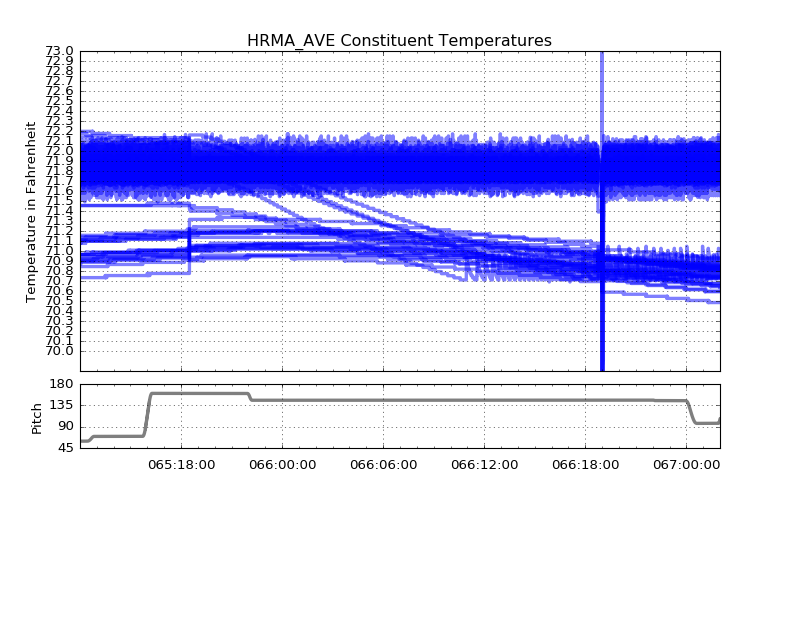

(736028.50018629304, 736030.08324193896)

In [12]:
plt.close(plt.gcf())
fig = plt.figure(facecolor=[1,1,1],figsize=(10,8))
ax = fig.add_axes([.1, .42, .8, .5])
ax.hold(True)
for msid in hmsids:
    plot_cxctime(plotdata[msid]['times'], plotdata[msid]['vals'], 
                label=msid, linewidth=3, alpha=0.5,
                fig=fig, ax=ax)
ax.set_xticklabels('')
ax.grid(True)
# ax.legend(loc='best')
ax.set_ylabel('Temperature in Fahrenheit')
ax.set_yticks(np.arange(70.0, 74.2, .1))
ax.set_ylim(69.8, 73.0)
ax.set_title('HRMA_AVE Constituent Temperatures')
fig.set_facecolor('w')
xlim = ax.get_xlim()

pitchtimes, pitchvals = gettelem('aosares1', t1, t2)

ax2 = fig.add_axes([.1, .3, .8, .1])
plot_cxctime(pitchtimes, pitchvals, 
                label='Pitch', color='black', linewidth=3, alpha=0.5,
                fig=fig, ax=ax2)
ax2.grid(True)
# ax.legend(loc='best')
ax2.set_ylabel('Pitch')
ax2.set_ylim(45, 160)
ax2.set_yticks([45, 90, 135, 180])
ax2.set_xlim(xlim)
